In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from google.colab import drive, files

In [10]:
NUM_KEYPOINTS = 17  # Number of keypoints (e.g., COCO format)
IMG_SIZE = 256  # Input image size
BATCH_SIZE = 16  # Batch size for training
EPOCHS = 2  # Number of training epochs
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# 1. Custom Dataset Class
class YogaPoseDataset(Dataset):
    def __init__(self, image_paths, keypoints, transform=None):
        self.image_paths = image_paths
        self.keypoints = keypoints
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        keypoints = self.keypoints[idx]  # Keypoints should be normalized to [0, 1]

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(keypoints, dtype=torch.float32)

In [12]:
# 2. ResNet-based Model for Keypoint Regression
class KeypointResNet(nn.Module):
    def __init__(self, num_keypoints):
        super().__init__()
        self.num_keypoints = num_keypoints
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(512, 2 * num_keypoints)  # Output (x, y) for each keypoint

    def forward(self, x):
        features = self.backbone(x)
        return features.view(-1, self.num_keypoints, 2)  # Reshape to (batch_size, num_keypoints, 2)

In [13]:
# 3. Training Function
def train_model(train_loader, val_loader):
    model = KeypointResNet(num_keypoints=NUM_KEYPOINTS).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for images, keypoints in train_loader:
            images = images.to(DEVICE)
            keypoints = keypoints.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, keypoints)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{EPOCHS} Loss: {running_loss/len(train_loader):.4f}")

    return model

In [14]:
# 4. Inference Function
def detect_pose_static(model, image_path):
    model.eval()
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        keypoints = model(input_tensor).cpu().numpy()[0]

    return keypoints

In [15]:
# 5. Visualization Function
def visualize_pose_static(image_path, keypoints):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    for x, y in keypoints:
        plt.scatter(x * IMG_SIZE, y * IMG_SIZE, s=50, c='red', marker='o')  # Scale keypoints to image size
    plt.show()

# 6. Extract Keypoints for All Images
def extract_keypoints_for_dataset(model, image_paths):
    keypoints_list = []
    for image_path in image_paths:
        keypoints = detect_pose_static(model, image_path)
        keypoints_list.append(keypoints.flatten())  # Flatten keypoints to 1D array
    return np.array(keypoints_list)

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]


Epoch 1/2 Loss: 0.1363
Epoch 2/2 Loss: 0.0899
Validation Accuracy: 19.64%


Saving Cow Pose-01.png to Cow Pose-01.png


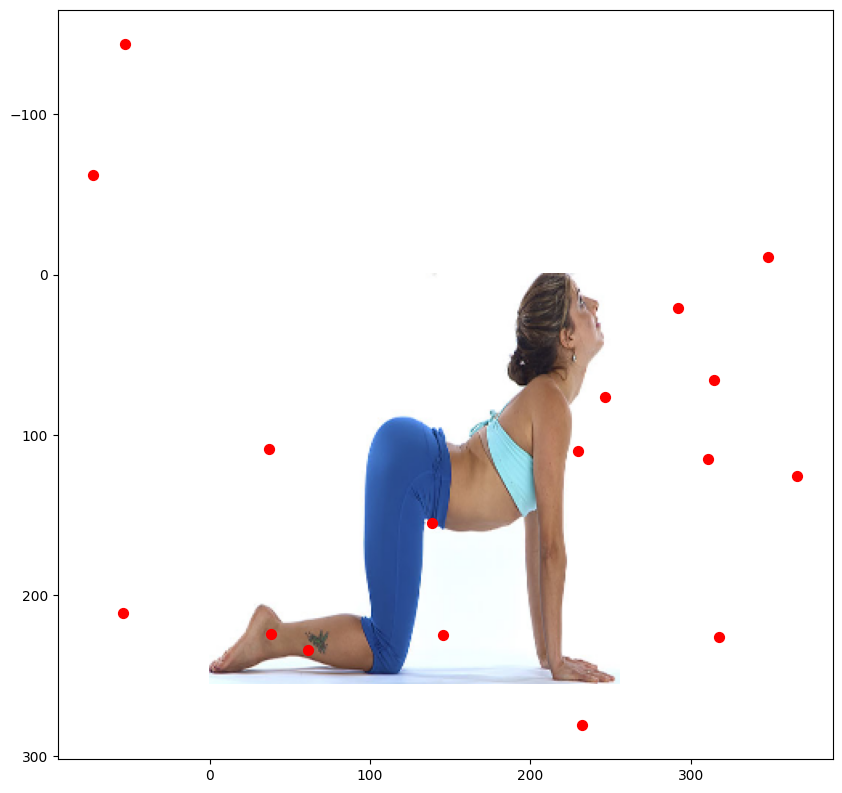

Predicted Pose: Cow Pose


In [16]:
# 7. Main Workflow
def main():
    # Mount Google Drive
    drive.mount('/content/drive')
    dataset_path = "/content/drive/MyDrive/Yoga-Pose-Dataset-V1"

    # Load dataset
    pose_data = []
    image_paths = []
    keypoints_list = []
    pose_labels = []
    for pose_class in os.listdir(dataset_path):
        pose_folder = os.path.join(dataset_path, pose_class)
        if not os.path.isdir(pose_folder):
            continue
        for img_file in os.listdir(pose_folder):
            img_path = os.path.join(pose_folder, img_file)
            image_paths.append(img_path)
            # Replace with actual keypoints (normalized to [0, 1])
            keypoints = np.random.rand(NUM_KEYPOINTS, 2)  # Replace with real data ###################################################################
            keypoints_list.append(keypoints)
            pose_labels.append(pose_class)  # Add pose class label
            pose_data.append({"pose": pose_class, "keypoints": keypoints.tolist()})

    # Train/test split
    train_paths, val_paths, train_keypoints, val_keypoints, train_labels, val_labels = train_test_split(
        image_paths, keypoints_list, pose_labels, test_size=0.2, random_state=42
    )

    # Create datasets and dataloaders
    train_dataset = YogaPoseDataset(train_paths, train_keypoints)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Train the ResNet model
    model = train_model(train_loader, val_loader=None)  # Skip validation for simplicity

    # Extract keypoints for all images
    X_train = extract_keypoints_for_dataset(model, train_paths)
    X_val = extract_keypoints_for_dataset(model, val_paths)

    # Train Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, train_labels)

    # Evaluate on validation set
    val_preds = clf.predict(X_val)
    accuracy = accuracy_score(val_labels, val_preds)
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")

    # Test on a new image
    uploaded = files.upload()
    test_image = list(uploaded.keys())[0]
    predicted_keypoints = detect_pose_static(model, test_image)
    visualize_pose_static(test_image, predicted_keypoints)

    # Predict pose for the test image
    test_keypoints = extract_keypoints_for_dataset(model, [test_image])
    predicted_pose = clf.predict(test_keypoints)[0]
    print(f"Predicted Pose: {predicted_pose}")

if __name__ == "__main__":
    main()